In [ ]:
import os
import csv
import pickle
import numpy as np
import pandas as pd
import warnings
import pprint as pp
warnings.filterwarnings(action='ignore')

import nltk
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from wordcloud import WordCloud
from gensim import corpora, models
from gensim.models import LdaMulticore
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.models.callbacks import CoherenceMetric
import gensim

from PIL import Image
import matplotlib.pyplot as plt
from bokeh.io import push_notebook, show, output_notebook, save, output_file
from bokeh.layouts import row
from bokeh.plotting import figure
from bokeh.palettes import RdBu
from bokeh.models import HoverTool, ColumnDataSource
plt.rcParams['font.family'] = 'AppleGothic'
output_notebook()

import pyLDAvis
import pyLDAvis.gensim
import pickle

from pkg import nlpfunc

random_state = 2023




# Load Data

In [ ]:
with open('../data/dongjack_article.pkl', 'rb') as f:
    Gu1_articles = pickle.load(f)
    
with open('../data/yeongdeungpo_article.pkl', 'rb') as f:
    Gu2_articles = pickle.load(f)

In [ ]:
print(Gu1_articles[:5]) 
print(Gu2_articles[:5]) 

# Preprocessing

### Remove stop words

In [ ]:

with open('../data/korean_stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = f.readlines()
stopwords = [x.replace('\n','') for x in stopwords]
addtional = ['기자', '이데일리', '뉴시스','언론','언론사', '도시', '주택', '계획', '사업',
             '일대', '지역', '추진','주민','시설', '구역', '가구','고','위','층',
             '말']
stopwords = stopwords + addtional

In [ ]:
## remove stopwords
case1 = ['동작', '동작구', '서울', '서울시']
stopwords_Gu1 = stopwords + case1


case2 = ['영등포', '영등포구', '서울', '서울시']
stopwords_Gu2 = stopwords + case2


In [ ]:
## extract nouns
_, word_list1 = nlpfunc.analyze_morph_extract_noun(Gu1_articles, stopwords_Gu1)
_, word_list2 = nlpfunc.analyze_morph_extract_noun(Gu2_articles, stopwords_Gu2)


### 추가 Stop word 생성을 위한 빈도수 확인

In [ ]:
def check_count_pos(model_name, pos):
    text = nltk.Text(pos, name = 'NMSC')
    print ('모델명: {}'.format(model_name))
    print ("토큰의 개수 : {}".format(len(text.tokens)))
    print ("unique 토큰의 개수 : {}".format(len(set(text.tokens))))
    print("상위 50개 빈도의 단어 : ")
    pp.pprint(text.vocab().most_common(20))
    
    print("Plot Chart")
    
    plt.figure(figsize = (20, 10))
    plt.rcParams.update({'font.size':20})
    text.plot(50)

In [ ]:
# 동작구 단어 빈도 확인
check_count_pos('동작구',word_list1)

In [ ]:
# stopword 추가
case1_add = ['개', '총', '내', '권', '비', '박민', '통해', '위해']
stopwords_Gu1 = stopwords_Gu1 + case1_add

In [ ]:
## 영등포구 단어 빈도 확인
check_count_pos('영등포구',word_list2)

In [ ]:
# stopword 추가
case2_add = ['개', '총', '내', '권', '비', '박민', '곳', '시', '비', '중', '안', '쪽', '위해', '통해', '청장']
stopwords_Gu2 = stopwords_Gu2 + case2_add

# Analysis

## Wordcloud 



In [ ]:
def make_wordcloud(word_dict, mask, cloud_set):
    wordcloud = WordCloud(
    font_path=cloud_set['font_path'],
    background_color = cloud_set['background_color'],
    colormap =cloud_set['colormap'],
    width=cloud_set['width'],
    height=cloud_set['height'],
    mask=cloud_set['mask']
    )

    wordcloud_words = wordcloud.generate_from_frequencies(word_dict)

    array = wordcloud.to_array()
    
    fit = plt.figure()
    plt.imshow(array, interpolation='bilinear')
    plt.axis('off')
    #plt.title('Word Cloud of Real Estate Articles')
    plt.show()

In [ ]:
## extract nouns
word_dict1, _ = nlpfunc.analyze_morph_extract_noun(Gu1_articles, stopwords_Gu1)
word_dict2, _ = nlpfunc.analyze_morph_extract_noun(Gu2_articles, stopwords_Gu2)

### 동작구

In [ ]:
mask_img_name = 'wordcloud_mask1.png'
mask = np.array(Image.open(os.path.join('../img', mask_img_name)))

In [ ]:
wordcloud = WordCloud()
## Word cloud
mask_img_name = 'wordcloud_mask2.png'
mask = np.array(Image.open(os.path.join('../img', mask_img_name)))

cloud_set = {'font_path': '..font/NanumGothicBold.otf',
             'background_color': 'White',
             'colormap': 'twilight',
             'width': 800,
             'height': 600,
             'mask': mask}
make_wordcloud(word_dict1, mask, cloud_set)

### 영등포구

In [ ]:
wordcloud = WordCloud()
## Word cloud
mask_img_name = 'wordcloud_mask2.png'
mask = np.array(Image.open(os.path.join('../img', mask_img_name)))

cloud_set = {'font_path':'..font/NanumGothicBold.otf',
              'background_color':'White',
              'colormap':'twilight',
              'width': 800,
              'height':600,
              'mask':mask}
make_wordcloud(word_dict2, mask, cloud_set )


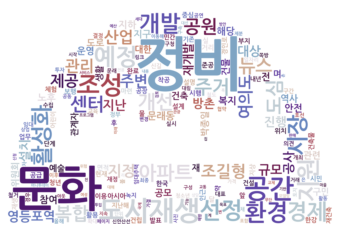

In [32]:
wordcloud = WordCloud()
## Word cloud
mask_img_name = 'wordcloud_mask2.png'
mask = np.array(Image.open(os.path.join('../img', mask_img_name)))

cloud_set = {'font_path':'..font/NanumGothicBold.otf',
              'background_color':'White',
              'colormap':'twilight',
              'width': 800,
              'height':600,
              'mask':mask}
make_wordcloud(word_dict2, mask, cloud_set )


## 유사한 단어 군집을 통해 이슈 분류

- Embedding: Word2Vec, 단어를 벡터로 바꿔준다. 단어를 벡터화 할 때 단어의 문맥적 의미를 보존할 수 있다
- 단어 간의 관계를 파악하는 Word Embedding을 이용하여 유사한 단어를 파악할 수 있다
- Tsne를 통해 비슷한 단어를 한 눈에 볼 수 있도록 시각화 한다

* 주요품사
    - NNG:	일반 명사
    - NNP:	고유 명사
    - VV:	동사
    - VA:	형용사
    - XR:	어근
    - SL:	알파벳(A-Z a-z)

In [33]:
n_word = ['NNG', 'NNP', 'VV', 'VA', 'XR', 'SL']
v_word = ['VV', 'VA']

### Word Embedding

In [36]:
from kiwipiepy import Kiwi
from kiwipiepy.utils import Stopwords
kiwi = Kiwi()

In [37]:
# stopword에 추가할 단어 포맷 변경
total_article_list = []
total_stop_words = stopwords_Gu1 + stopwords_Gu2
add_stopwords = []
for temp in [kiwi.tokenize(x) for x in total_stop_words]:
    add_stopwords.extend([(x.form, x.tag) for x in temp if ('-I' not in x.tag) and ('-R' not in x.tag)])
    

In [38]:

kiwi_stopwords = Stopwords()
kiwi_stopwords.add(set(add_stopwords))

In [39]:
def make_sentence_list(setences, stopwords):
    sentences_list = []
    morph_list = [kiwi.tokenize(x, normalize_coda=True, stopwords=stopwords) for x in setences]
    for morph in morph_list:
        filter_w = [m for m in morph if m.tag in n_word ]
        filter_w = [m.form+'다' if m.tag in v_word else m.form for m in filter_w]
        sentences_list.append(filter_w)
    return sentences_list
        

#### 동작구

In [40]:
sentences_list1 = make_sentence_list(Gu1_articles, kiwi_stopwords)
sentences_list1[0][:10]



['교육', '환경', '영향', '평가', '통과', '노량진', '학원가', '일대', '전경', '아시아']

In [41]:
emb_1 = Word2Vec(sentences_list1, vector_size = 1000,
                 window = 3, min_count = 5, workers = 4,
                 epochs = 1000, sg = 1)

In [42]:
emb_1.wv.index_to_key[:10]

['청년', '조성', '재생', '안전', '마을', '밝히다', '공간', '건축', '동', '지원']

In [43]:
emb_1.wv.most_similar('평가')

[('영향', 0.4421446621417999),
 ('심의', 0.35109519958496094),
 ('과정', 0.3508889675140381),
 ('아시아', 0.29583078622817993),
 ('전주', 0.2944321930408478),
 ('열람', 0.28793466091156006),
 ('속도', 0.2872171401977539),
 ('제출', 0.28683722019195557),
 ('강남', 0.2817912995815277),
 ('조사', 0.28132718801498413)]

In [44]:
emb_1.wv.most_similar('상승세')

[('집값', 0.5986903309822083),
 ('규제', 0.5168193578720093),
 ('보이다', 0.5138095617294312),
 ('강남', 0.4898085296154022),
 ('전주', 0.4879952073097229),
 ('커지다', 0.47857335209846497),
 ('이어지다', 0.465284526348114),
 ('앞두다', 0.4642541706562042),
 ('택지', 0.4590553343296051),
 ('영향', 0.4380476176738739)]

#### 영등포구

In [45]:
sentences_list2 = make_sentence_list(Gu2_articles, kiwi_stopwords)
sentences_list2[0][:10]


['이승주', '타임스퀘어', '인근', '규모', '관광', '호텔', '들어서다', '영등포동', '가', '번지']

In [46]:
emb_2 = Word2Vec(sentences_list2, vector_size = 1000,
                 window = 3, min_count = 5, workers = 4,
                 epochs = 1000, sg = 1)

In [47]:
emb_2.wv.index_to_key[:10]

['정비', '재생', '개발', '공간', '문화', '조성', '일대', '환경', '지원', '예정']

In [48]:
emb_2.wv.most_similar('개발')

[('집값', 0.2975984513759613),
 ('당초', 0.24608196318149567),
 ('지적', 0.24044476449489594),
 ('신길역', 0.23641343414783478),
 ('플랜', 0.23396587371826172),
 ('장기', 0.23375967144966125),
 ('편입', 0.22647248208522797),
 ('지구', 0.2264607697725296),
 ('붙다', 0.22099263966083527),
 ('상승세', 0.22017225623130798)]

### Tsne 시각화

In [49]:
def make_embedded_frame(embeddinng_model, print_head=True):
    emd_list = []
    for k in embeddinng_model.wv.index_to_key:
        emd_list.append(embeddinng_model.wv[k])
    emd_frame = pd.DataFrame(emd_list, index=embeddinng_model.wv.index_to_key)
    if print_head:
        print(emd_frame.head())
    return emd_frame

In [50]:
def create_tsne_frame(embedded_frame,print_head=True):
    tsne = TSNE(random_state=random_state, n_components=2, 
               perplexity=10,
               learning_rate=0.1,
               early_exaggeration=5)
    tsne_point = tsne.fit_transform(embedded_frame.values)
    tsne_df = pd.DataFrame(tsne_point, index=embedded_frame.index,
                          columns=['x_coord', 'y_coord'])
    tsne_df['word'] = embedded_frame.index
    if print_head:
        print(tsne_df.head())
    return tsne_df

#### 동작구

In [51]:
emd_frame1 = make_embedded_frame(emb_1)

         0         1         2         3         4         5         6    \
청년  0.058252 -0.068833  0.014789  0.095542 -0.153259  0.085201  0.024563   
조성  0.069335  0.133024  0.117530 -0.278123  0.021693 -0.018050 -0.104643   
재생  0.023476  0.042076  0.065620 -0.129943  0.226364  0.093001 -0.067650   
안전  0.024495  0.168306  0.001955  0.117885 -0.094240  0.014509  0.152569   
마을 -0.280042  0.005286 -0.120956 -0.346832 -0.032857 -0.062175 -0.011154   

         7         8         9    ...       990       991       992       993  \
청년  0.155368 -0.019128 -0.035170  ... -0.207477  0.057648  0.250269  0.061491   
조성  0.100268 -0.060819  0.039825  ...  0.047786 -0.013193 -0.008080  0.072883   
재생 -0.164959  0.341099  0.196124  ... -0.047712  0.071065 -0.083820 -0.173442   
안전  0.022670 -0.060304  0.189860  ...  0.062829 -0.113019 -0.164044 -0.042577   
마을 -0.010796  0.110865  0.096309  ...  0.114442 -0.166516 -0.058814 -0.209803   

         994       995       996       997       998    

In [52]:
t_df1 = create_tsne_frame(emd_frame1)

     x_coord   y_coord word
청년  3.214462 -2.350290   청년
조성 -0.999310 -4.997361   조성
재생 -1.154630 -4.379227   재생
안전 -4.419866 -3.026614   안전
마을 -3.151322 -5.985423   마을


In [53]:
plot_data = ColumnDataSource(t_df1)
colors = ["#%02x%02x%02x"]

TOOLS="hover,pan,wheel_zoom,zoom_in,\
zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,\
poly_select,lasso_select,"


p = figure(tools = TOOLS, title = '동작구 Real Estate Issues')
p.add_tools(HoverTool(tooltips = '@word'))

p.circle('x_coord', 'y_coord', source = plot_data,
        fill_alpha = 0.1, line_alpha = 0.3, 
        color='red', size = 10)


p.xaxis.visible = False
p.yaxis.visible = False
p.grid.grid_line_color = None
p.outline_line_color = None
show(p)

In [54]:
output_file("../outputs/tsne_dongjak.html")
save(p)

'/Users/jeonsohyun/Library/CloudStorage/OneDrive-숭실대학교-SoongsilUniversity/project/real_estate_issues/outputs/tsne_dongjak.html'

#### 영등포구

In [ ]:
emd_frame2 = make_embedded_frame(emb_2)
t_df2 = create_tsne_frame(emd_frame2)

In [ ]:
plot_data = ColumnDataSource(t_df2)
colors = ["#%02x%02x%02x"]

TOOLS="hover,pan,wheel_zoom,zoom_in,\
zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,\
poly_select,lasso_select,"


p = figure(tools = TOOLS, title = '영등포구 Real Estate Issues')
p.add_tools(HoverTool(tooltips = '@word'))

p.circle('x_coord', 'y_coord', source = plot_data,
        fill_alpha = 0.1, line_alpha = 0.3, 
        color='blue', size = 10)


p.xaxis.visible = False
p.yaxis.visible = False
p.grid.grid_line_color = None
p.outline_line_color = None
show(p)

In [ ]:
output_file("../outputs/tsne_youngdeungpo.html")
save(p)

## LDA
* 숨겨진 (latent) 레이어를 이용하여 컨텐츠의 주제를 파악해 볼 수 있다
* 추출된 주제의 연과된 단어를 시각화를 통해 쉽게 파악할 수 있다

### Make Topics

In [365]:
def make_dict_corpus(token_list):
    cor_dict = corpora.Dictionary(token_list)
    cor_dict.filter_extremes(no_below=5)
    corpus = [cor_dict.doc2bow(text) for text in token_list]
    return cor_dict, corpus

In [392]:
# 최적의 토픽 개수 확인
def compute_coherences(corpus, dictionary, sentences, start=2, limit=10, step=2, show=True):
    coherence_values = []

    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=random_state)
        c_model = CoherenceModel(model, texts=sentences, 
                       dictionary=dictionary, coherence='c_v')
        coherence_values.append(c_model.get_coherence())
    
    if show:
        x = range(start, limit, step)
        plt.plot(x, coherence_values)
        plt.xticks(np.arange(0, limit, step))
        plt.xlabel("Num Topics")
        plt.ylabel("Coherence score")
        plt.legend(("coherence_values"), loc='best')
        plt.show()
        
    return coherence_values

In [379]:
def get_coherence_scores(model, sentences, dictionary):
    #c_v : 응집성 (0~1)
    coherence = CoherenceModel(model=model, 
                                 texts=sentences,
                                 dictionary=dictionary,
                                 coherence='c_v')
    cv_score = coherence.get_coherence()
    print(f'c_v : {cv_score}')

    #u_mass : 일관성, 0에 가까울수록 좋음
    coherence = CoherenceModel(model=model, 
                                 texts=sentences,
                                 dictionary=dictionary,
                                 coherence='u_mass')
    umass_score = coherence.get_coherence()
    print(f'u_mass : {umass_score}')
    
    return cv_score, umass_score

#### 동작구

In [368]:
cor_dict1, corpus1 = make_dict_corpus(sentences_list1)

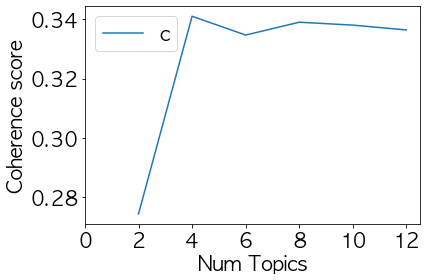

In [393]:
coh_list = compute_coherences(corpus1, cor_dict1, sentences_list1, limit=14)



In [394]:
# LDA 모델 학습
best_n_topic1 = 4
lda_model1 = LdaModel(corpus1, 
                    num_topics = best_n_topic1, 
                    id2word=cor_dict1,
                    random_state=random_state,
                    passes=30)


In [395]:
## score
_, _ = get_coherence_scores(lda_model1, sentences_list1, cor_dict1 )


c_v : 0.357687043806437
u_mass : -3.584661386255601


#### 영등포구

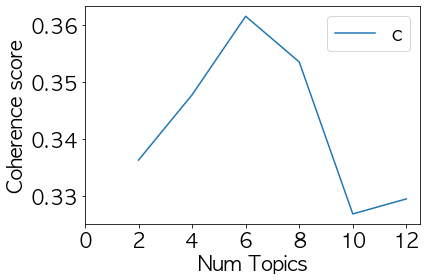

In [397]:
cor_dict2, corpus2 = make_dict_corpus(sentences_list2)
coh_list2 = compute_coherences(corpus2, cor_dict2, sentences_list2, limit=14)

In [398]:
best_n_topic2 = 6
lda_model2 = LdaModel(corpus2, 
                    num_topics = best_n_topic2, 
                    id2word=cor_dict2,
                    random_state=random_state,
                    passes=30)

In [399]:
_, _ = get_coherence_scores(lda_model2, sentences_list2, cor_dict2 )

c_v : 0.4093162782366003
u_mass : -2.75857508574736


### Visualize Topics

#### 동작구

In [403]:
ldavis1= pyLDAvis.gensim.prepare(topic_model = lda_model1,
                               corpus = corpus1, 
                               dictionary = cor_dict1)
pyLDAvis.display(ldavis1)

In [407]:
pyLDAvis.save_html(ldavis1, '../outputs/lda_visualize_dongjak.html')

#### 영등포구

In [404]:
ldavis2= pyLDAvis.gensim.prepare(topic_model = lda_model2,
                               corpus = corpus2, 
                               dictionary = cor_dict2)
pyLDAvis.display(ldavis2)

In [409]:
pyLDAvis.save_html(ldavis2, '../outputs/lda_visualize_youngdeungpo.html')